In [1]:
#-------------------#
#   Module Import   #
#-------------------#

import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import pandas as pd
import numpy as np
import pickle
import glob
import copy
import sys

from pathlib import Path
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.convolution import Gaussian1DKernel, convolve
from matplotlib.backends.backend_pdf import PdfPages

workdir = Path.cwd() / '../'
sys.path.append(str(workdir / 'lib'))
sys.path.append('/usr/local/lib/python3.7/site-packages')

from py_specrebin import rebinspec
from smooth_gauss import gauss_ivar

# Package can be installed through: pip install ppxf
# Documentation can be found on https://pypi.org/project/ppxf/
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

In [2]:
#---------------------------#
#   Constants Definitions   #
#---------------------------#

CONST = {'C':299792.458}

In [3]:
#--------------------------#
#   Plotting  Parameters   #
#--------------------------#

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['figure.figsize'] = (14.0, 8.0)

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 30}

plt.rc('font', **font)
plt.rc('text', usetex=True)


#--------------------#
#   Custom Colours   #
#--------------------#

tableau10 = {
    'GRAY':np.array([199, 199, 199])/255,
    'BLUE':np.array([174, 199, 232])/255,
    'ORANGE':np.array([255, 187, 120])/255,
    'GREEN':np.array([152, 223, 138])/255,
    'RED':np.array([255, 152, 150])/255,
    'PURPLE':np.array([197, 176, 213])/255,
    'BROWN':np.array([196, 156, 148])/255,
    'PINK':np.array([247, 182, 210])/255,
    'CYAN':np.array([158, 218, 229])/255,
    'YELLOW':np.array([219, 219, 141])/255
}

In [4]:
#-----------------------#
#   Class Definitions   #
#-----------------------#
       
class Spectrum:
    
    def __init__(self, wavelength, flux, ivar):
        
        flux[flux < 0] = 0
        noise = np.nan_to_num(np.sqrt(1/ivar))
        noise[noise > 1e+7] = 999.
        noise[noise < 1e-7] = 0
        
        self.wavelength = wavelength
        self.flux = flux
        self.ivar = ivar
        self.noise = noise  
        
    @classmethod
    def from_HDU(cls, hdu):
        return cls(hdu['LAMBDA'][0], hdu['SPEC'][0], hdu['IVAR'][0])
    
    @classmethod
    def with_noise(cls, wavelength, flux, noise):
        a = cls(wavelength, flux, np.array([1]))
        a.noise = noise
        a.ivar = 1 / noise**2
        
        return a

In [5]:
#--------------------------#
#   Function Definitions   #
#--------------------------#

def read_HDU(hdu):
    
    try:
        if 'Bxspf-B' in hdu and 'Bxspf-R' in hdu:
            blue_name = 'Bxspf-B'
            red_name = 'Bxspf-R'
            
        else:
            blue_name = 'Horne-B'
            red_name = 'Horne-R'
            
        wavelength_b = f[blue_name].data['LAMBDA'][0]
        wavelength_r = f[red_name].data['LAMBDA'][0]

        flux_b = f[blue_name].data['SPEC'][0]
        flux_r = f[red_name].data['SPEC'][0]

        ivar_b = f[blue_name].data['IVAR'][0]
        ivar_r = f[red_name].data['IVAR'][0]
        
        wb = np.arange(
            np.min(wavelength_b), 
            np.max(wavelength_b), 
            wavelength_b[1] - wavelength_b[0]
        )
        
        wr = np.arange(
            np.min(wavelength_r), 
            np.max(wavelength_r), 
            wavelength_b[1] - wavelength_b[0]
        )

    except KeyError:
        return None
    except ValueError:
        return None
    
    flux_b, ivar_b = np.nan_to_num(rebinspec(wavelength_b, flux_b, wb, ivar = ivar_b))
    flux_r, ivar_r = np.nan_to_num(rebinspec(wavelength_r, flux_r, wr, ivar = ivar_r))
    
    flux = np.append(flux_b, flux_r)
    w = np.append(wb, wr)
    ivar = np.append(ivar_b, ivar_r)
    
    return Spectrum(w, flux, ivar)


def ppxf_run(log_spec, param):
    
    if not np.sum(log_spec.flux) > 0:
        return 0, 0
    
    ppxf_result = ppxf(
        param['TEMPLATE_FLUX'], 
        log_spec.flux, 
        param['NOISE'], 
        param['VELSCALE'], 
        param['START'], 
        goodpixels = param['GOOD_PIXELS'], 
        plot = param['PLOT'], 
        moments = 2, 
        degree = 12, 
        vsyst = param['DV'], 
        clean = False, 
        lam = np.exp(log_spec.wavelength), 
        quiet = 1
    )

    return ppxf_result

In [6]:
#-------------------------#
#   Code Initialization   #
#-------------------------#

# Preparing the template files for PPXF to use as reference
template_files = glob.glob(
    str(workdir / 'lib' / 'ppxf' / 'DEIMOS_600' / 'template*.fits')
)

head = fits.open(template_files[0])[0].header
template_wavelength = head['CRVAL1'] + head['CDELT1']*np.arange(head['NAXIS1'])
template_wavelength_range = (template_wavelength[0], template_wavelength[-1])

linear_template_fluxes = np.zeros((len(template_files), len(template_wavelength)))

for ind, file in enumerate(template_files):
    linear_template_fluxes[ind, :] = fits.open(file)[0].data[0]


# Load the config file that will let the program know which files to run PPXF on
config_file = ascii.read(workdir / 'Kadri' / 'DEIMOS_VUGC_copy.conf').to_pandas()
config_file.columns = map(str.upper, config_file.columns)
config_file = config_file.set_index('OBJECT')


# Prepare the A-Band correction polynomial supplied by Kevin McKinnon
poly = {}
poly['COSMOS'] = np.load(workdir / 'Kadri' / 'galaxy_LSF_output/COSMOS.deltaLambdaFit.npy')
poly['EGS'] = np.load(workdir / 'Kadri' / 'galaxy_LSF_output/EGS.deltaLambdaFit.npy')
poly['GOODSN'] = np.load(workdir / 'Kadri' / 'galaxy_LSF_output/GOODSN.deltaLambdaFit.npy')

aband_poly = np.poly1d(
    (poly['COSMOS'] + poly['EGS'] + poly['GOODSN'])[:, 0]/3
)


In [7]:
if not Path(workdir / 'Kadri' / 'vdgc_dataframe_w_spectra.obj').exists():

    file = workdir / 'catalogs' / 'VDGC_pPXF_2017_v2.fits'
    data = Table.read(file)

    if 'VDGC' in str(file):
        
        columns_to_change = [
            'ZERR', 'ZERR_ne', 'ZERR_pe', 
            'ZHEL', 'HELCOR',
            'ZOBS', 'ZOBS_ne', 'ZOBS_pe',
            'ABANDCOR', 'ABANDCOR_ne', 'ABANDCOR_pe'
        ]

        for col in columns_to_change:
            data[col] = data[col] * 3e+5
            if col[0] is 'Z':
                data.rename_column(col, 'V' + col[1:])

    
    data = data.to_pandas()

    # Astropy Table writes strings in bytestrings. Fix that to UTF-8
    for col in data.columns:
        if type(data[col][0]) is bytes:
            data[col] = data[col].str.decode('utf-8')  

    data = data.set_index('SPEC1DNAME')
    data['FILE_INFO'] = None

    for index, row in data.iterrows():

        file_path = workdir / 'spectra' / index

        if file_path.exists():
            f = fits.open(file_path)
        elif Path(str(file_path)[:-3]).exists():
            f = fits.open(Path(str(file_path)[:-3]))
        else:
            print(index)
            raise FileNotFoundError

        data.loc[index, 'FILE_INFO'] = read_HDU(f)   

    fout = open('vdgc_dataframe_w_spectra.obj', 'wb')
    pickle.dump(data, fout)
    fout.close()

In [8]:
data = pickle.load(open(workdir / 'Kadri' / 'vugc_dataframe_w_spectra.obj', 'rb'))
# data = pickle.load(open('/Users/kmohamad/Dropbox/Kadri_Nizam/ppxf/vdgc_dataframe_w_spectra.obj', 'rb'))

none_index = [ind for ind, x in enumerate(data['FILE_INFO']) if x is None ]
clean_data = data.drop(data.index[none_index], axis = 0)

In [11]:
def run_program(index, conf_row, clean_data):

    #-----------------------#
    #    Analysis Section   #
    #-----------------------#
    row = clean_data.loc[index]
        
    redshift = row['VOBS'] / CONST['C']
    ppxf_lambda_range = (conf_row['LAMBMIN'], conf_row['LAMBMAX'])
    std_dev = conf_row['STDDEV']
        
    spec = row['FILE_INFO']
    file_lambda_range = (spec.wavelength[0], spec.wavelength[-1])
    file_delta_lambda = spec.wavelength[1] - spec.wavelength[0]
    
    ppxf_lambda_mask = (
        (spec.wavelength >= ppxf_lambda_range[0]) &\
        (spec.wavelength <= ppxf_lambda_range[1])
    )

    spec.wavelength = spec.wavelength[ppxf_lambda_mask]
    spec.flux = spec.flux[ppxf_lambda_mask]
    spec.ivar = spec.ivar[ppxf_lambda_mask]
    spec.noise = spec.noise[ppxf_lambda_mask]
    
    aband_lambda_correction = (
        (row['ABANDCOR']*7600*aband_poly(spec.wavelength))
        / (CONST['C']*aband_poly(7600))
    )

    flux, ivar = np.nan_to_num(
        rebinspec(
            spec.wavelength - aband_lambda_correction, 
            spec.flux, 
            spec.wavelength, 
            ivar = spec.ivar
        )
    )
    
    linear_spec = Spectrum(spec.wavelength, flux, ivar)
    
    frac = linear_spec.wavelength[1] / linear_spec.wavelength[0]
    velscale = np.log(frac) * CONST['C']
    
    log_flux, log_wavelength, log_velscale = np.nan_to_num(util.log_rebin(
            ppxf_lambda_range, linear_spec.flux, velscale = velscale
    ))
    
    log_noise, _, _ = np.nan_to_num(util.log_rebin(
            ppxf_lambda_range, linear_spec.noise, velscale = velscale
    ))
    
    log_noise /= np.median(log_flux[log_flux > 0])
    log_flux /= np.median(log_flux[log_flux > 0])
    ppxf_noise = np.full_like(log_flux, 0.0166) 
    
    a_b_band = (
        ((log_wavelength>np.log(6800)) & (log_wavelength<np.log(7000))) |
        ((log_wavelength>np.log(7550)) & (log_wavelength<np.log(7700))) 
    )
    
    log_flux[a_b_band] = 0.
    
    log_spec = Spectrum.with_noise(log_wavelength, log_flux, log_noise)
    
    good_pixels = np.arange(len(log_wavelength))
    good_pixels = good_pixels[log_flux != 0]
    
    num_pixels = len(util.log_rebin(
        template_wavelength_range, linear_template_fluxes[0], velscale = velscale)[0])

    log_template_fluxes = np.empty((num_pixels, len(template_files)))
    
    for ind, temp_row in enumerate(linear_template_fluxes):
        log_template_fluxes[:, ind], _, _ = util.log_rebin(
            template_wavelength_range,
            temp_row,
            velscale = velscale
        )
        
    log_template_fluxes = np.nan_to_num(log_template_fluxes)
    log_template_fluxes[log_template_fluxes > 1e+7] = 999.
    log_template_fluxes[log_template_fluxes < 1e-7] = 0.
    
    velocity = np.log(1 + row['VOBS']/CONST['C'])
    
    params = {
        'TEMPLATE_FLUX': log_template_fluxes,
        'NOISE': ppxf_noise,
        'VELSCALE': velscale,
        'START': [velocity, 3*velscale],
        'GOOD_PIXELS': good_pixels,
        'PLOT': False,
        'DV': np.log(template_wavelength[0]/spec.wavelength[0]) * CONST['C']
    }
    
    result = ppxf_run(log_spec, params)
    
    #----------------------------#
    #   Monte-Carlo Simulation   #
    #----------------------------#
    
    num_iter = 100
    
    MC = {'VEL':np.zeros(num_iter), 'SIGMA':np.zeros(num_iter)}
    mc_spec = copy.deepcopy(log_spec)
    params['START'] = result.sol
    params['NOISE'] = abs(log_spec.noise)
    params['PLOT'] = False
    
    
    for ii in range(num_iter):
        mc_spec.flux = np.random.normal(log_spec.flux, params['NOISE'])
        mc_spec.flux /= np.median(mc_spec.flux)
        pp_mc = ppxf_run(mc_spec, params)
        MC['VEL'][ii], MC['SIGMA'][ii] = pp_mc.sol[0], pp_mc.sol[1]
    

    
    #-----------------------#
    #    Plotting Section   #
    #-----------------------#
    with PdfPages(str(workdir / 'lib' / 'ppxf' / 'figures2' / conf_row.name) + '.pdf') as pdf:
    
        # Prepare data to plot
        residuals = result.galaxy - result.bestfit

        x_range = (np.min(result.lam), np.max(result.lam))
        # y_range = (np.min(result.bestfit[result.goodpixels]), 
        #            np.max(result.bestfit[result.goodpixels]))

        g_kernel = Gaussian1DKernel(stddev = conf_row['STDDEV'])

        smoothed_flux, smoothed_ivar = gauss_ivar(
            linear_spec.wavelength, 
            linear_spec.flux, 
            linear_spec.ivar, 
            conf_row['STDDEV']
        )

        smoothed_flux /= np.median(smoothed_flux)
        redshift = result.sol[0]/CONST['C']

        # Start plot
        fig, (ax1, ax2) = plt.subplots(
            2, 1, sharex = True, 
            gridspec_kw={'hspace': 0, 'height_ratios': [2, 1]})


        fig.suptitle(f'SNR: {round(np.median(log_spec.flux)/np.median(log_spec.noise), 2)}')
        plt.xlabel('$\lambda$ [$\AA$]')
        plt.xlim(x_range + np.array([-0.05, 0.05])*np.diff(x_range))

        # Shade regions in which we performed the PPXF fits
        w = np.flatnonzero(np.diff(result.goodpixels) > 1)

        if w.size > 0:

            w = np.hstack([0, w, w + 1, -1])  # Add first and last point

        #     for wj in w:
        #         j = slice(result.goodpixels[wj] + 1, result.goodpixels[wj + 1] - 1)
        #         ax2.plot(result.lam[j], residuals[j], 'tab:blue', marker = 'o', linestyle = 'None', ms = 0.1)

            for ii in range(0, len(w)-1, 2):
                x1 = result.goodpixels[w[ii]]
                x2 = result.goodpixels[w[ii + 1]]

                ax1.axvspan(result.lam[x1], result.lam[x2], color = 'tab:blue', alpha = 0.08)
                ax2.axvspan(result.lam[x1], result.lam[x2], color = 'tab:blue', alpha = 0.08)

        #     for gj in result.goodpixels[w]:
        #         ax1.axvline(result.lam[gj], color = 'tab:blue', linestyle = '--')
        #         ax2.axvline(result.lam[gj], color = 'tab:blue', linestyle = '--')


        #------------#
        #   Axis 1   #
        #------------#
        ax1.plot(linear_spec.wavelength/(1 + redshift), smoothed_flux, color = 'tab:gray', label = 'Flux')

        ax1.plot(
            result.lam/(1 + redshift), convolve(result.bestfit, g_kernel, boundary = 'extend'),
            color = 'tab:red', linewidth = 2, label = 'PPXF Fit')

        ax1.legend(frameon = False, prop={'size': 25}, loc = 3)
        ax1.set_ylabel('Normalized Counts')
        ax1.get_xaxis().set_ticks_position('both')

        #------------#
        #   Axis 2   #
        #------------#
        ax2.axhline(color = 'tab:gray', linestyle = '--')

        ax2.plot(
            result.lam[result.goodpixels]/(1 + redshift), residuals[result.goodpixels],
            linestyle = 'None' , marker = 'd', color = 'tab:green', mec = 'tab:green', 
            markersize = 2.5, label = 'Residual')

        ax2.set_ylabel('Residuals')

        #--------------#
        #    Common    #
        #--------------#
        for ax in [ax1, ax2]:
            ax.minorticks_on()
            ax.tick_params(axis = 'both', which = 'both', direction = 'in')
            ax.tick_params(axis = 'both', which = 'major', length = 8, width = 2)
            ax.tick_params(axis = 'both', which = 'minor', length = 3, width = 1)

            ax.get_yaxis().set_ticks_position('both')


        fig.align_ylabels([ax1, ax2])
        pdf.savefig()

        if x_range[0] < 5250:
            plt.xlim((4800, 5250))
            ax1.axvline(4861, color = 'k', linestyle = ':')  # H-Beta
            ax1.axvline(5015, color = 'k', linestyle = ':')  # Fe-5015
            ax1.axvline(5167, color = 'k', linestyle = ':')  # Mg-1
            ax1.axvline(5173, color = 'k', linestyle = ':')  # Mg-2
            ax1.axvline(5184, color = 'k', linestyle = ':')  # Mg-3

            pdf.savefig()

        if np.min(result.lam[result.goodpixels])> 6100 and np.min(result.lam[result.goodpixels]) < 6750:
            plt.xlim((6100, 6750))
            ax1.axvline(6563, color = 'k', linestyle = ':')  # H-Alpha

            pdf.savefig()

        plt.xlim((8300, 8800))
        ax1.axvline(8498, color = 'k', linestyle = ':')  # Ca-1
        ax1.axvline(8542, color = 'k', linestyle = ':')  # Ca-2
        ax1.axvline(8662, color = 'k', linestyle = ':')  # Ca-1

        pdf.savefig()
        plt.close()

        plt.figure()
        med = np.median(MC['VEL'])
        percentile16 = np.percentile(MC['VEL'], 16)
        percentile84 = np.percentile(MC['VEL'], 84)

        values, bins, patches = plt.hist(MC['VEL'], facecolor = tableau10['BLUE'])
        plt.axvline(med, color = 'k', linestyle = '--')
        plt.axvline(percentile16, color = 'k', linestyle = ':')
        plt.axvline(percentile84, color = 'k', linestyle = ':')

        ax = plt.gca()
        ax.minorticks_on()
        ax.tick_params(axis = 'both', which = 'both', direction = 'in')
        ax.tick_params(axis = 'both', which = 'major', length = 8, width = 2)
        ax.tick_params(axis = 'both', which = 'minor', length = 3, width = 1)
        ax.tick_params(axis = 'both', which = 'major', pad = 15)

        ax.get_xaxis().set_ticks_position('both')
        ax.get_yaxis().set_ticks_position('both')

        plt.title('$V = %.3f^{+\,%.3f}_{-\,%.3f}$' % (med, percentile84-med, med-percentile16))
        plt.ylabel('Counts')
        plt.xlabel('$V\\, [\\textrm{km}\\,s^{-1}]$')

        pdf.savefig()
        plt.close()

        plt.figure()
        med = np.median(MC['SIGMA'])
        percentile16 = np.percentile(MC['SIGMA'], 16)
        percentile84 = np.percentile(MC['SIGMA'], 84)

        values, bins, patches = plt.hist(MC['SIGMA'], facecolor = tableau10['PINK'])
        plt.axvline(med, color = 'k', linestyle = '--')
        plt.axvline(percentile16, color = 'k', linestyle = ':')
        plt.axvline(percentile84, color = 'k', linestyle = ':')

        ax = plt.gca()
        ax.minorticks_on()
        ax.tick_params(axis = 'both', which = 'both', direction = 'in')
        ax.tick_params(axis = 'both', which = 'major', length = 8, width = 2)
        ax.tick_params(axis = 'both', which = 'minor', length = 3, width = 1)
        ax.tick_params(axis = 'both', which = 'major', pad = 15)

        ax.get_xaxis().set_ticks_position('both')
        ax.get_yaxis().set_ticks_position('both')

        plt.title('$\\sigma = %.3f^{+\,%.3f}_{-\,%.3f}$' % (med, percentile84-med, med-percentile16))
        plt.ylabel('Counts')
        plt.xlabel('$\\sigma\\, [\\textrm{km}\\,s^{-1}]$')

        pdf.savefig()
        plt.close()

In [12]:
import timeit
start_time = timeit.default_timer()

[run_program(index, conf_row, clean_data) for index, conf_row in config_file.iterrows()]


elapsed = timeit.default_timer() - start_time

AttributeError: 'tuple' object has no attribute 'sol'

NameError: name 'conf_row' is not defined

In [12]:
print(elapsed/3600)

1.987694243138889


In [17]:
pool = mp.Pool(processes = 8)

result = [pool.apply_async(run_program, args=(index, conf_row, clean_data))
    for index, conf_row in config_file.head(n = 4).iterrows()]

In [ ]:
result[0].get()

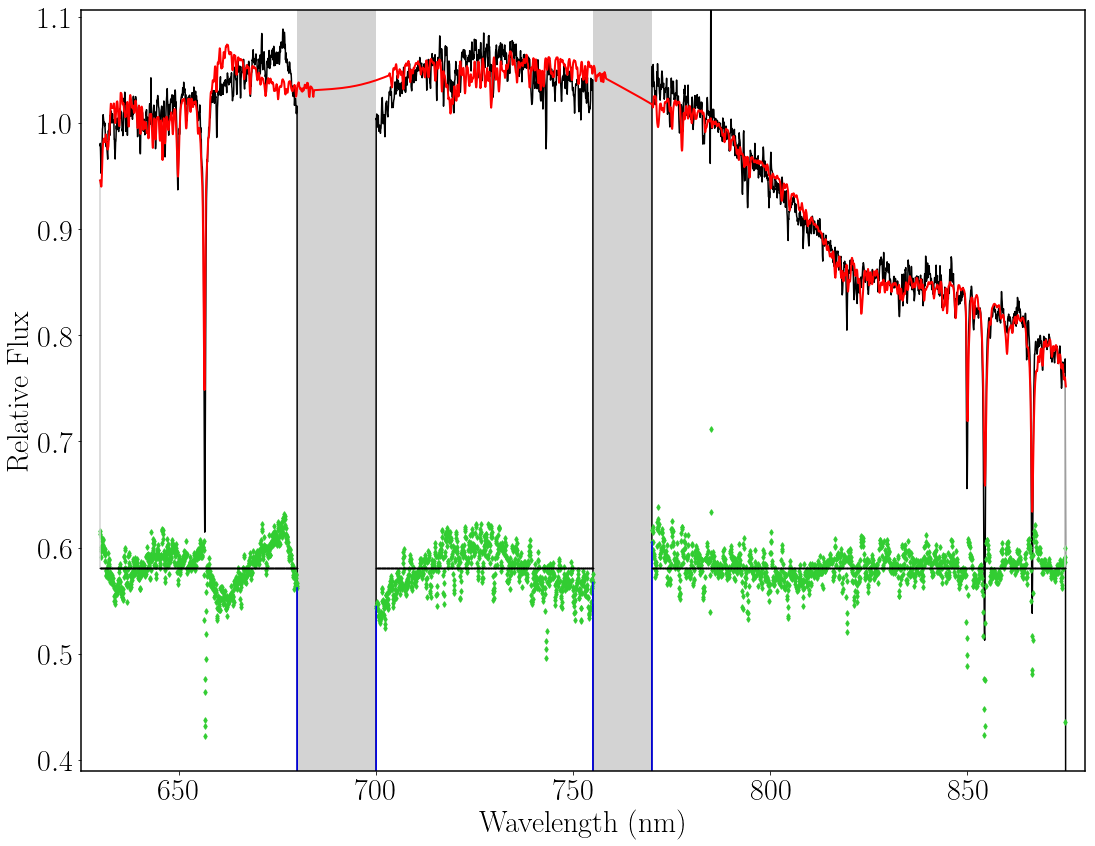

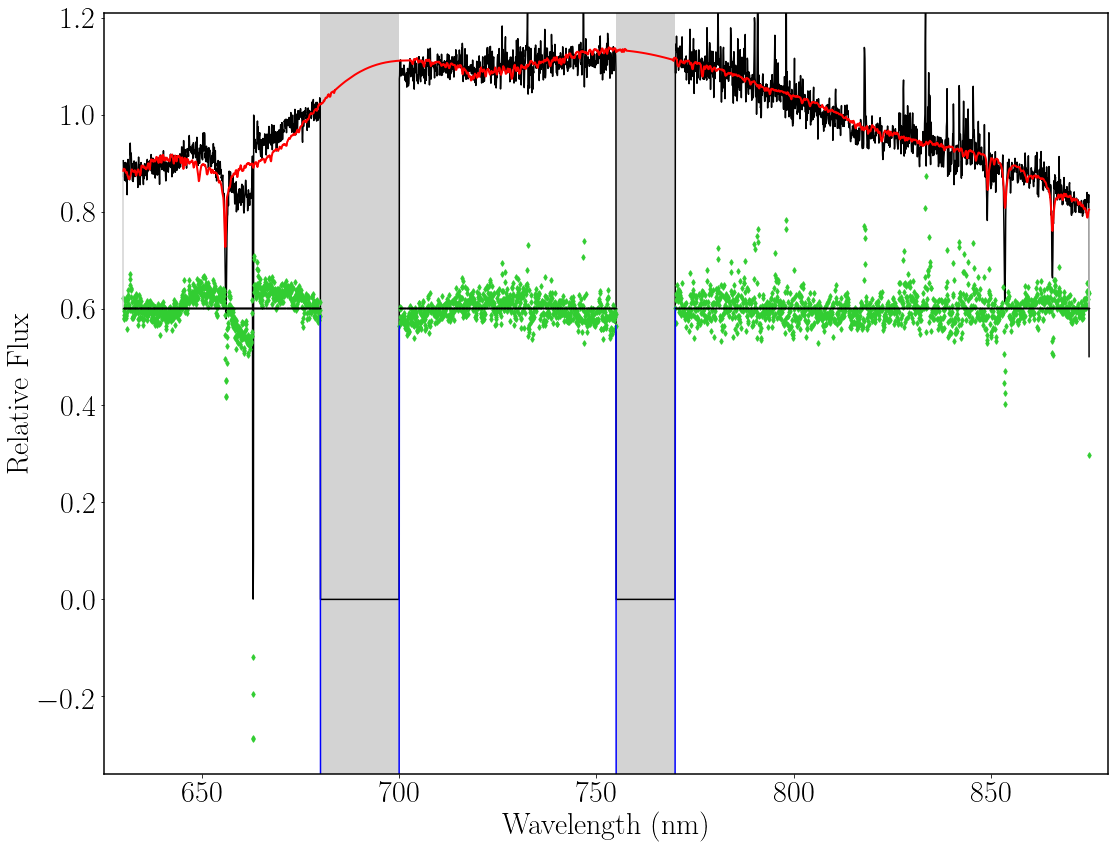

In [38]:
for index, conf_row in config_file.head(n=2).iterrows():

    row = clean_data.loc[index + '.gz']
        
    redshift = row['VOBS'] / CONST['C']
    ppxf_lambda_range = (conf_row['LAMBMIN'], conf_row['LAMBMAX'])
    std_dev = conf_row['STDDEV']
        
    spec = row['FILE_INFO']
    file_lambda_range = (spec.wavelength[0], spec.wavelength[-1])
    file_delta_lambda = spec.wavelength[1] - spec.wavelength[0]
    
    ppxf_lambda_mask = (
        (spec.wavelength >= ppxf_lambda_range[0]) &\
        (spec.wavelength <= ppxf_lambda_range[1])
    )

    spec.wavelength = spec.wavelength[ppxf_lambda_mask]
    spec.flux = spec.flux[ppxf_lambda_mask]
    spec.ivar = spec.ivar[ppxf_lambda_mask]
    spec.noise = spec.noise[ppxf_lambda_mask]
    
    aband_lambda_correction = (
        (row['ABANDCOR']*7600*aband_poly(spec.wavelength))
        / (CONST['C']*aband_poly(7600))
    )

    flux, ivar = np.nan_to_num(
        rebinspec(
            spec.wavelength - aband_lambda_correction, 
            spec.flux, 
            spec.wavelength, 
            ivar = spec.ivar
        )
    )
    
    linear_spec = Spectrum(spec.wavelength, flux, ivar)
    
    frac = linear_spec.wavelength[1] / linear_spec.wavelength[0]
    velscale = np.log(frac) * CONST['C']
    
    log_flux, log_wavelength, log_velscale = np.nan_to_num(util.log_rebin(
            ppxf_lambda_range, linear_spec.flux, velscale = velscale
    ))
    
    log_noise, _, _ = np.nan_to_num(util.log_rebin(
            ppxf_lambda_range, linear_spec.noise, velscale = velscale
    ))
    
    log_noise /= np.median(log_flux[log_flux > 0])
    log_flux /= np.median(log_flux[log_flux > 0])
    ppxf_noise = np.full_like(log_flux, 0.0166) 
    
    a_b_band = (
        ((log_wavelength>np.log(6800)) & (log_wavelength<np.log(7000))) |
        ((log_wavelength>np.log(7550)) & (log_wavelength<np.log(7700))) 
    )
    
    log_flux[a_b_band] = 0.
    
    log_spec = Spectrum.with_noise(log_wavelength, log_flux, log_noise)
    
    good_pixels = np.arange(len(log_wavelength))
    good_pixels = good_pixels[log_flux != 0]
    
    num_pixels = len(util.log_rebin(
        template_wavelength_range, linear_template_fluxes[0], velscale = velscale)[0])

    log_template_fluxes = np.empty((num_pixels, len(template_files)))
    
    for ind, temp_row in enumerate(linear_template_fluxes):
        log_template_fluxes[:, ind], _, _ = util.log_rebin(
            template_wavelength_range,
            temp_row,
            velscale = velscale
        )
        
    log_template_fluxes = np.nan_to_num(log_template_fluxes)
    log_template_fluxes[log_template_fluxes > 1e+7] = 999.
    log_template_fluxes[log_template_fluxes < 1e-7] = 0.
    
    velocity = np.log(1 + row['VOBS']/CONST['C'])
    
    params = {
        'TEMPLATE_FLUX': log_template_fluxes,
        'NOISE': ppxf_noise,
        'VELSCALE': velscale,
        'START': [velocity, 3*velscale],
        'GOOD_PIXELS': good_pixels,
        'PLOT': False,
        'DV': np.log(template_wavelength[0]/spec.wavelength[0]) * CONST['C']
    }
    
    result = ppxf_run(log_spec, params)
    
    #----------------------------#
    #   Monte-Carlo Simulation   #
    #----------------------------#
    
    num_iter = 100
    
    MC = {'VEL':np.zeros(num_iter), 'SIGMA':np.zeros(num_iter)}
    mc_spec = copy.deepcopy(log_spec)
    params['START'] = result.sol
    params['NOISE'] = abs(log_spec.noise)
    params['PLOT'] = False
    
    
    for ii in range(num_iter):
        mc_spec.flux = np.random.normal(log_spec.flux, params['NOISE'])
        mc_spec.flux /= np.median(mc_spec.flux)
        pp_mc = ppxf_run(mc_spec, params)
        MC['VEL'][ii], MC['SIGMA'][ii] = pp_mc.sol[0], pp_mc.sol[1]

In [39]:
from matplotlib.backends.backend_pdf import PdfPages


with PdfPages(str(workdir / 'lib' / 'ppxf' / 'figures' / conf_row.name) + '.pdf') as pdf:
    
    # Prepare data to plot
    residuals = result.galaxy - result.bestfit

    x_range = (np.min(result.lam), np.max(result.lam))
    # y_range = (np.min(result.bestfit[result.goodpixels]), 
    #            np.max(result.bestfit[result.goodpixels]))

    g_kernel = Gaussian1DKernel(stddev = conf_row['STDDEV'])

    smoothed_flux, smoothed_ivar = gauss_ivar(
        linear_spec.wavelength, 
        linear_spec.flux, 
        linear_spec.ivar, 
        conf_row['STDDEV']
    )

    smoothed_flux /= np.median(smoothed_flux)
    redshift = result.sol[0]/CONST['C']

    # Start plot
    fig, (ax1, ax2) = plt.subplots(
        2, 1, sharex = True, 
        gridspec_kw={'hspace': 0, 'height_ratios': [2, 1]})


    fig.suptitle(f'SNR: {round(np.median(log_spec.flux)/np.median(log_spec.noise), 2)}')
    plt.xlabel('$\lambda$ [$\AA$]')
    plt.xlim(x_range + np.array([-0.05, 0.05])*np.diff(x_range))

    # Shade regions in which we performed the PPXF fits
    w = np.flatnonzero(np.diff(result.goodpixels) > 1)

    if w.size > 0:

        w = np.hstack([0, w, w + 1, -1])  # Add first and last point

    #     for wj in w:
    #         j = slice(result.goodpixels[wj] + 1, result.goodpixels[wj + 1] - 1)
    #         ax2.plot(result.lam[j], residuals[j], 'tab:blue', marker = 'o', linestyle = 'None', ms = 0.1)

        for ii in range(0, len(w)-1, 2):
            x1 = result.goodpixels[w[ii]]
            x2 = result.goodpixels[w[ii + 1]]

            ax1.axvspan(result.lam[x1], result.lam[x2], color = 'tab:blue', alpha = 0.08)
            ax2.axvspan(result.lam[x1], result.lam[x2], color = 'tab:blue', alpha = 0.08)

    #     for gj in result.goodpixels[w]:
    #         ax1.axvline(result.lam[gj], color = 'tab:blue', linestyle = '--')
    #         ax2.axvline(result.lam[gj], color = 'tab:blue', linestyle = '--')


    #------------#
    #   Axis 1   #
    #------------#
    ax1.plot(linear_spec.wavelength/(1 + redshift), smoothed_flux, color = 'tab:gray', label = 'Flux')

    ax1.plot(
        result.lam/(1 + redshift), convolve(result.bestfit, g_kernel, boundary = 'extend'),
        color = 'tab:red', linewidth = 2, label = 'PPXF Fit')

    ax1.legend(frameon = False, prop={'size': 25}, loc = 3)
    ax1.set_ylabel('Normalized Counts')
    ax1.get_xaxis().set_ticks_position('both')

    #------------#
    #   Axis 2   #
    #------------#
    ax2.axhline(color = 'tab:gray', linestyle = '--')

    ax2.plot(
        result.lam[result.goodpixels]/(1 + redshift), residuals[result.goodpixels],
        linestyle = 'None' , marker = 'd', color = 'tab:green', mec = 'tab:green', 
        markersize = 2.5, label = 'Residual')

    ax2.set_ylabel('Residuals')

    #--------------#
    #    Common    #
    #--------------#
    for ax in [ax1, ax2]:
        ax.minorticks_on()
        ax.tick_params(axis = 'both', which = 'both', direction = 'in')
        ax.tick_params(axis = 'both', which = 'major', length = 8, width = 2)
        ax.tick_params(axis = 'both', which = 'minor', length = 3, width = 1)

        ax.get_yaxis().set_ticks_position('both')


    fig.align_ylabels([ax1, ax2])
    pdf.savefig()
    
    if x_range[0] < 5250:
        plt.xlim((4800, 5250))
        ax1.axvline(4861, color = 'k', linestyle = ':')  # H-Beta
        ax1.axvline(5015, color = 'k', linestyle = ':')  # Fe-5015
        ax1.axvline(5167, color = 'k', linestyle = ':')  # Mg-1
        ax1.axvline(5173, color = 'k', linestyle = ':')  # Mg-2
        ax1.axvline(5184, color = 'k', linestyle = ':')  # Mg-3
        
        pdf.savefig()

    if np.min(result.lam[result.goodpixels])> 6100 and np.min(result.lam[result.goodpixels]) < 6750:
        plt.xlim((6100, 6750))
        ax1.axvline(6563, color = 'k', linestyle = ':')  # H-Alpha
        
        pdf.savefig()

    plt.xlim((8300, 8800))
    ax1.axvline(8498, color = 'k', linestyle = ':')  # Ca-1
    ax1.axvline(8542, color = 'k', linestyle = ':')  # Ca-2
    ax1.axvline(8662, color = 'k', linestyle = ':')  # Ca-1
    
    pdf.savefig()
    
    plt.close()
    
    plt.figure()

    med = np.median(MC['VEL'])
    percentile16 = np.percentile(MC['VEL'], 16)
    percentile84 = np.percentile(MC['VEL'], 84)

    values, bins, patches = plt.hist(MC['VEL'], facecolor = tableau10['BLUE'])
    plt.axvline(med, color = 'k', linestyle = '--')
    plt.axvline(percentile16, color = 'k', linestyle = ':')
    plt.axvline(percentile84, color = 'k', linestyle = ':')

    ax = plt.gca()
    ax.minorticks_on()
    ax.tick_params(axis = 'both', which = 'both', direction = 'in')
    ax.tick_params(axis = 'both', which = 'major', length = 8, width = 2)
    ax.tick_params(axis = 'both', which = 'minor', length = 3, width = 1)
    ax.tick_params(axis = 'both', which = 'major', pad = 15)

    ax.get_xaxis().set_ticks_position('both')
    ax.get_yaxis().set_ticks_position('both')

    plt.title('$V = %.3f^{+\,%.3f}_{-\,%.3f}$' % (med, percentile84-med, med-percentile16))
    plt.ylabel('Counts')
    plt.xlabel('$V\\, [\\textrm{km}\\,s^{-1}]$')

    pdf.savefig()
    
    plt.close()
    
    plt.figure()

    med = np.median(MC['SIGMA'])
    percentile16 = np.percentile(MC['SIGMA'], 16)
    percentile84 = np.percentile(MC['SIGMA'], 84)

    values, bins, patches = plt.hist(MC['SIGMA'], facecolor = tableau10['PINK'])
    plt.axvline(med, color = 'k', linestyle = '--')
    plt.axvline(percentile16, color = 'k', linestyle = ':')
    plt.axvline(percentile84, color = 'k', linestyle = ':')

    ax = plt.gca()
    ax.minorticks_on()
    ax.tick_params(axis = 'both', which = 'both', direction = 'in')
    ax.tick_params(axis = 'both', which = 'major', length = 8, width = 2)
    ax.tick_params(axis = 'both', which = 'minor', length = 3, width = 1)
    ax.tick_params(axis = 'both', which = 'major', pad = 15)

    ax.get_xaxis().set_ticks_position('both')
    ax.get_yaxis().set_ticks_position('both')

    plt.title('$\\sigma = %.3f^{+\,%.3f}_{-\,%.3f}$' % (med, percentile84-med, med-percentile16))
    plt.ylabel('Counts')
    plt.xlabel('$\\sigma\\, [\\textrm{km}\\,s^{-1}]$')

    pdf.savefig()
    
    plt.close()